In [5]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
path= "/kaggle/input/spam-data/spam_and_ham_classification.csv"
df= pd.read_csv(path )
df = df.rename(columns={"label": "Class", "text": "Message"})
print(df.shape)
df.head()

(9989, 2)


,Class,Message
0,ham,into the kingdom of god and those that are ent...
1,spam,there was flow at hpl meter 1505 on april firs...
2,ham,take a look at this one campaign for bvyhprice...
3,spam,somu wrote actually thats what i was looking f...
4,spam,fathi boudra wrote i fixed the issue in the sv...


In [10]:
df.Class.value_counts()

Class
ham     5294
spam    4695
Name: count, dtype: int64

<Axes: ylabel='count'>

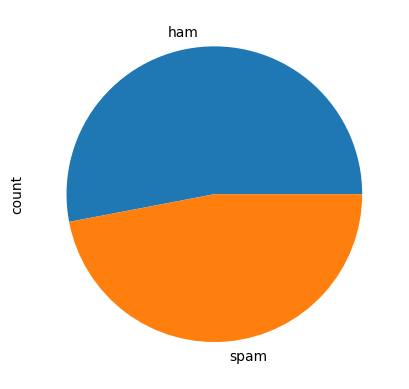

In [11]:
df.Class.value_counts().plot(kind="pie")

In [12]:
df["Message"]

0       into the kingdom of god and those that are ent...
1       there was flow at hpl meter 1505 on april firs...
2       take a look at this one campaign for bvyhprice...
3       somu wrote actually thats what i was looking f...
4       fathi boudra wrote i fixed the issue in the sv...
                              ...                        
9984    this would be a great tragedy for all concerne...
9985    hello , welcome to medzonline filamentous shop...
9986    this is amazing stuff add some inches fast saf...
9987    author jra date escapenumber escapenumber esca...
9988    anatrim escapenumber the newest and most attra...
Name: Message, Length: 9989, dtype: object

In [13]:
df.isna().sum()

Class      0
Message    0
dtype: int64

In [14]:
mapping = {
    "spam": 0,
     "ham": 1 
}

df["Status"] = df["Class"].map(mapping)

In [15]:
df.Status.value_counts()

Status
1    5294
0    4695
Name: count, dtype: int64

# Text preprocessing
## 1- reomve stop words , lemmatizer

In [9]:
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

# تحميل الموارد
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [23]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]
    cleaned_words = [w for w in lemmatized_words if w not in stop_words]
    
    return ' '.join(cleaned_words)

df["Message_clean"] = df["Message"].apply(preprocess_text)

In [32]:
print(preprocess_text("He is writing a letter"))


write letter


In [33]:
df

,Class,Message,Status,Message_clean
0,ham,into the kingdom of god and those that are ent...,1,kingdom god enter lord pardon escapenumber u t...
1,spam,there was flow at hpl meter 1505 on april firs...,0,flow hpl meter april first deal ticket deal ti...
2,ham,take a look at this one campaign for bvyhprice...,1,take look one campaign bvyhprice escapenumber ...
3,spam,somu wrote actually thats what i was looking f...,0,somu write actually thats look l r user enter ...
4,spam,fathi boudra wrote i fixed the issue in the sv...,0,fathi boudra write fix issue svn repo rev esca...
...,...,...,...,...
9984,ham,this would be a great tragedy for all concerne...,1,would great tragedy concerned situation digiti...
9985,ham,"hello , welcome to medzonline filamentous shop...",1,hello welcome medzonline filamentous shop plea...
9986,ham,this is amazing stuff add some inches fast saf...,1,amaze stuff add inch fast safe effective see n...
9987,spam,author jra date escapenumber escapenumber esca...,0,author jra date escapenumber escapenumber esca...


## 2- TF-IDF

In [34]:
cv = TfidfVectorizer(min_df=1)

df_tfidf = cv.fit_transform(df["Message_clean"])  # ده Sparse Matrix
#df_tfidf = pd.DataFrame(df_tfidf.toarray(), columns=cv.get_feature_names_out())

print(df_tfidf.shape)
#df_tfidf.head()


(9989, 83876)


# X,y selection

In [35]:
X = df_tfidf
y = df["Status"]

print(X.shape, y.shape)

(9989, 83876) (9989,)


# Create Model 

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# تقييم الموديل
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.968968968968969
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       940
           1       0.98      0.96      0.97      1058

    accuracy                           0.97      1998
   macro avg       0.97      0.97      0.97      1998
weighted avg       0.97      0.97      0.97      1998



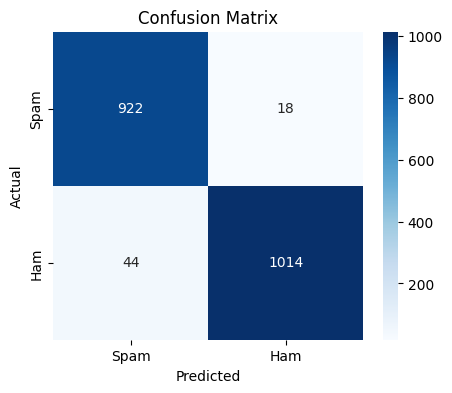

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# نحسب الـ confusion matrix
cm = confusion_matrix(y_test, y_pred)

# نرسمها
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Spam", "Ham"],
            yticklabels=["Spam", "Ham"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# make Test

In [39]:
test_messages = [
  """
Google News Alert
""" 
]

test_features = cv.transform(test_messages)

prediction = model.predict(test_features)  # نجيب أول نتيجة فقط
if prediction == 1:
    result = "ham"
else:
    result = "spam"
print(result)

# for msg, pred in zip(test_messages, prediction):
#     print(f"النص: {msg}")
#     print(f"التصنيف: {pred} : {result}" )
#     print("-" * 50)

spam


# Save

In [40]:
import joblib

# حفظ الموديل والفيكتورايزر
joblib.dump(model, "spam_classifier.pkl")
joblib.dump(cv, "vectorizer.pkl")


['vectorizer.pkl']